In [ ]:
defungi_dataset_path = "/Code/Datasets/DeFungi"

In [8]:
import sys
import wget
import requests
import os
from PIL import Image, ImageDraw
from IPython.display import display
from torchvision import transforms as pth_transforms

from models import VisionTransformer, vit_tiny, vit_small, vit_base, vit_large
from models import SwinTransformer, swin_tiny, swin_small, swin_base

import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [9]:
from glob import glob
import os
import PIL.Image
import math
from torchvision.transforms.functional import pil_to_tensor


labels = ["H1", "H2", "H3", "H5", "H6"]

def load_defungi(path, sample_per_label = 400, training_percent = 0.8):
    if not os.path.isdir(path):
        raise Exception(f"{path} path does not exist")
    
    label_dict = {}

    for label in labels:
        label_dict[label] = []
        for file in glob(os.path.join(path, label, "*.jpg")):
            label_dict[label].append(PIL.Image.open(file).resize(size=(224, 224)))
    
    train_ds = []
    eval_ds = []
    train_count = math.floor(sample_per_label * training_percent)
    test_count = sample_per_label - train_count

    for label in labels:
        for i in range(train_count):
            if i < len(label_dict[label]):
                train_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} train samples for {label}")
                break

        for i in range(train_count, train_count + test_count):
            if i < len(label_dict[label]):
                eval_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} eval samples for {label}")
                break

    return pd.DataFrame(train_ds), pd.DataFrame(eval_ds)

train_df, eval_df = load_defungi(defungi_dataset_path)
display(train_df)
display(eval_df)

,image,label,y
0,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
1,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
2,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
3,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
4,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
...,...,...,...
1595,<PIL.Image.Image image mode=RGB size=224x224 a...,H6,4
1596,<PIL.Image.Image image mode=RGB size=224x224 a...,H6,4
1597,<PIL.Image.Image image mode=RGB size=224x224 a...,H6,4
1598,<PIL.Image.Image image mode=RGB size=224x224 a...,H6,4


,image,label,y
0,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
1,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
2,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
3,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
4,<PIL.Image.Image image mode=RGB size=224x224 a...,H1,0
...,...,...,...
395,<PIL.Image.Image image mode=RGB size=224x224 a...,H6,4
396,<PIL.Image.Image image mode=RGB size=224x224 a...,H6,4
397,<PIL.Image.Image image mode=RGB size=224x224 a...,H6,4
398,<PIL.Image.Image image mode=RGB size=224x224 a...,H6,4


In [10]:
class DeFungiDataset(Dataset):
    def __init__(self, df):
        super().__init__()

        self.df = df

        self.y = df.iloc[:, 2]

        df = df.apply(lambda row: pil_to_tensor(row["image"]), axis=1)
        self.x = torch.stack(df.tolist(), dim=0)
        
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

        self.x /= 255.0
        #self.x = F.interpolate(self.x, size=(224, 224), mode='bilinear', antialias=True)
        print(self.y.shape)
        print(self.x.shape)
        
    def shape(self):
        return self.x.shape

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

eval_ds = DeFungiDataset(eval_df)
train_ds = DeFungiDataset(train_df)

/tmp/ipykernel_373660/3786422853.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([400])
torch.Size([400, 3, 224, 224])
torch.Size([1600])
torch.Size([1600, 3, 224, 224])


array([[<Axes: title={'center': 'y'}>]], dtype=object)

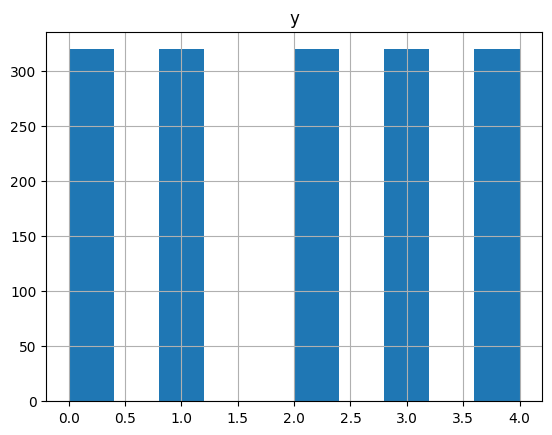

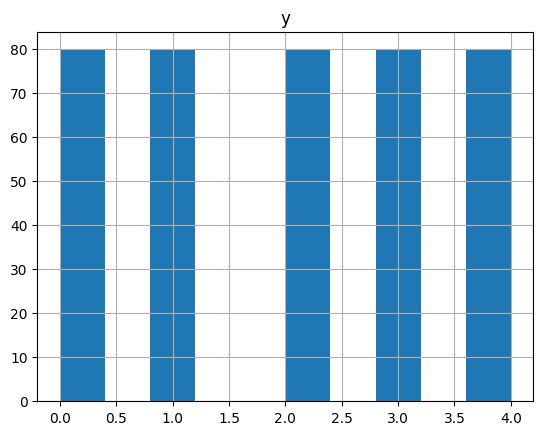

In [11]:
train_df.hist(column = 'y')
eval_df.hist(column = 'y')

In [12]:
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
test_loader = DataLoader(eval_ds, batch_size=10, shuffle=False)

/tmp/ipykernel_373660/3786422853.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5, 3, 224, 224])
    H1      H2      H3      H5      H6


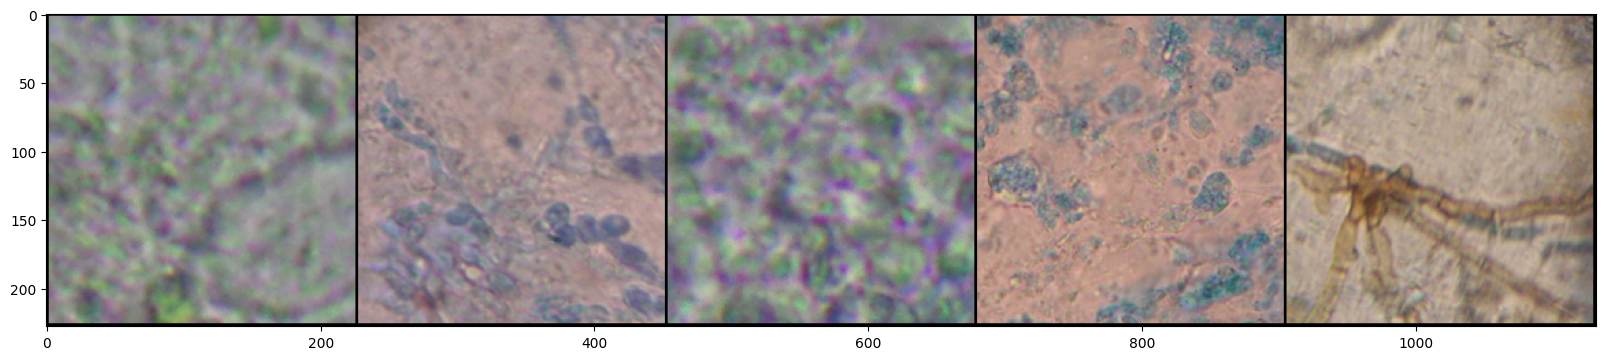

In [13]:
first_df = train_df.groupby('label', as_index=False).first()
first_dataset = DeFungiDataset(first_df)

images, l = first_dataset[:]
print(images.shape)

im = make_grid(images, nrow=len(first_df))
plt.figure(figsize=(20,8))
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))

labels_string = "      ".join(labels)
print("    " + labels_string)

In [14]:
def bar_progress(current, total, width=80):
  progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
  # Don't use print() as it will print in new line every time.
  sys.stdout.write("\r" + progress_message)
  sys.stdout.flush()

model_url = 'https://lf3-nlp-opensource.bytetos.com/obj/nlp-opensource/archive/2022/ibot/vitb_16/checkpoint_teacher.pth'
model_path = 'model.pth'

wget.download(model_url, model_path, bar=bar_progress)


Downloading: 6% [24215552 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 16% [61489152 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 26% [99090432 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 37% [142082048 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 48% [184074240 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 60% [226508800 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 71% [269312000 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 82% [310755328 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 93% [353910784 / 376848009] bytes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Downloading: 100% [376848009 / 376848009] bytes

'model (8).pth'

In [15]:
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
test_loader = DataLoader(eval_ds, batch_size=10, shuffle=False)

/tmp/ipykernel_373660/3786422853.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5, 3, 224, 224])
    H1      H2      H3      H5      H6


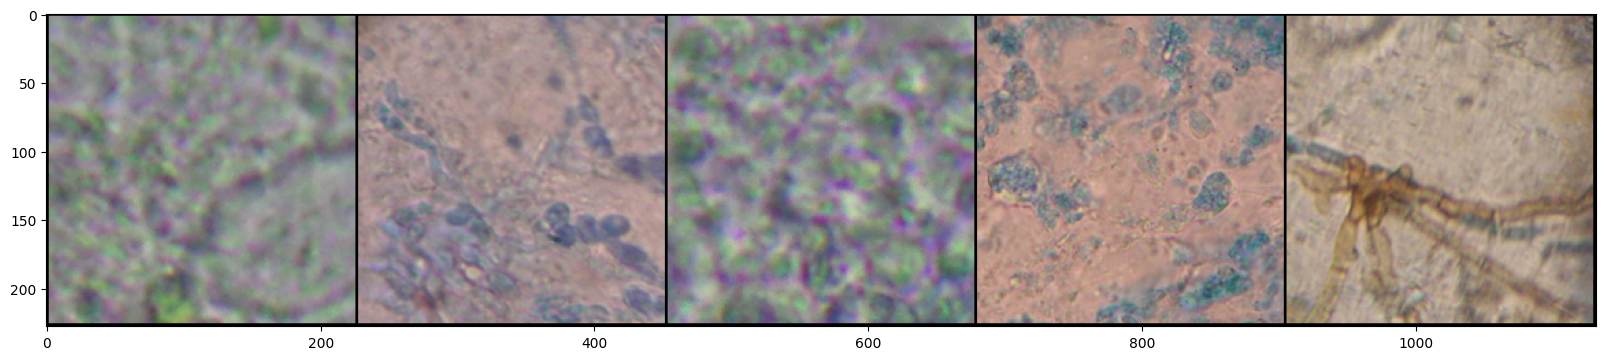

In [16]:
first_df = train_df.groupby('label', as_index=False).first()
first_dataset = DeFungiDataset(first_df)

images, l = first_dataset[:]
print(images.shape)

im = make_grid(images, nrow=len(first_df))
plt.figure(figsize=(20,8))
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))

labels_string = "      ".join(labels)
print("    " + labels_string)

In [17]:
# Defining the network architecture

class DeFungiModel(nn.Module):
    
    def __init__(self):       
        super().__init__()
        state_dict = torch.load(model_path)['state_dict']
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
        vit = vit_base(patch_size=16, return_all_tokens=True).cuda()
        vit.load_state_dict(state_dict, strict=False)
        vit.eval()
        for p in vit.parameters():
            p.requires_grad = False    

        self.backbone_model = vit      
        self.backbone_model.cuda()

        #self.fc1 = nn.Linear(in_features=3072, out_features=512)
        #self.fc2 = nn.Linear(in_features=512, out_features=128)
        #self.fc3 = nn.Linear(in_features=128, out_features=len(labels))

        self.fc1 = nn.Linear(in_features=3072, out_features=len(labels))

    def forward(self, X):
        X = self.backbone_model.get_intermediate_layers(X.cuda(), 4)
        X = [x[:, 0] for x in X]
        X = torch.cat(X, dim=-1)  
        #X = F.relu(self.fc1(X))
        #X = F.relu(self.fc2(X))
    
        #return F.log_softmax(input=self.fc3(X), dim=1)  
        return F.log_softmax(input=self.fc1(X), dim=1)

In [18]:
# Training the model
epochs = 20

writer = SummaryWriter('DeFungiLog')

model = DeFungiModel()
model = model.cuda()

start_time = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
accuracy_graph = []
precision_graph = []
recall_graph = [] 

for i in range(epochs):
    tst_corr = 0
    trn_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%28 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_df)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    writer.add_scalar("Loss/train", loss, i)     
    train_losses.append(loss.cpu().detach().numpy())

    # Test model per epoch
    model.eval()
    y_true_label = []
    predictions = []

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
            y_true_label.extend(y_test.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())
            
        
    accuracy = accuracy_score(y_true_label, predictions)
    precision = precision_score(y_true_label, predictions, average="macro")
    recall = recall_score(y_true_label, predictions, average="macro")

    accuracy_graph.append(accuracy)
    precision_graph.append(precision)
    recall_graph.append(recall)

    writer.add_scalar("accuracy/test", tst_corr, i)
    model.train()

    loss = criterion(y_val,y_test)
    test_losses.append(loss.cpu().detach().numpy())
    print(f'test accuracy: {accuracy*100:7.2f}, precision: {precision*100:7.2f}, recall: {recall*100:7.2f}')
    torch.save(model.state_dict(), f"DeFungiEpoch/DeFungiModel_Epoch_{i}.pt")
    
total_time = time.time() - start_time
print(f'\nDuration: {total_time:.0f} seconds')

epoch:  0  batch:   28 [   280/1600]  loss: 2.07312846  accuracy:  54.643%
epoch:  0  batch:   56 [   560/1600]  loss: 0.40163237  accuracy:  63.036%
epoch:  0  batch:   84 [   840/1600]  loss: 1.02234125  accuracy:  66.667%
epoch:  0  batch:  112 [  1120/1600]  loss: 0.19736615  accuracy:  71.875%
epoch:  0  batch:  140 [  1400/1600]  loss: 1.32211161  accuracy:  73.143%
test accuracy:   61.25, precision:   67.83, recall:   61.25
epoch:  1  batch:   28 [   280/1600]  loss: 0.18847466  accuracy:  90.000%
epoch:  1  batch:   56 [   560/1600]  loss: 0.19493546  accuracy:  88.214%
epoch:  1  batch:   84 [   840/1600]  loss: 0.37870842  accuracy:  87.976%
epoch:  1  batch:  112 [  1120/1600]  loss: 0.54254335  accuracy:  89.375%
epoch:  1  batch:  140 [  1400/1600]  loss: 0.09504547  accuracy:  89.429%
test accuracy:   64.00, precision:   65.70, recall:   64.00
epoch:  2  batch:   28 [   280/1600]  loss: 0.37436593  accuracy:  93.571%
epoch:  2  batch:   56 [   560/1600]  loss: 0.12840500 

In [19]:
model.load_state_dict(torch.load("DeFungiEpoch/DeFungiModel_Epoch_3.pt"))
model.eval()

test_load_all = DataLoader(eval_ds, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for b, (X_test, y_test) in enumerate(test_load_all):
        y_val = model(X_test.cuda())
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test.cuda()).sum()
print(f'Test Accuracy: {correct.item()/len(eval_df)*100:.2f}%')
predicted = predicted.cpu()

OutOfMemoryError: CUDA out of memory. Tried to allocate 230.00 MiB. GPU 

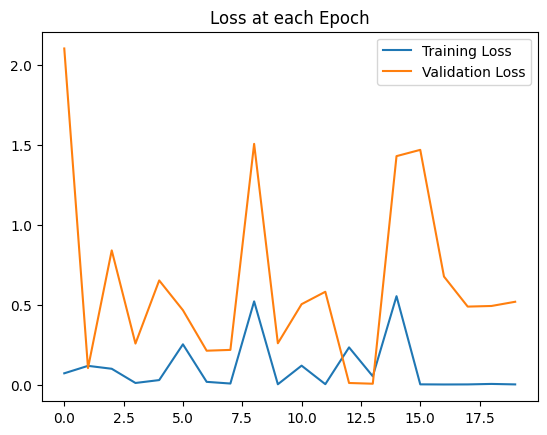

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at each Epoch')
plt.legend()

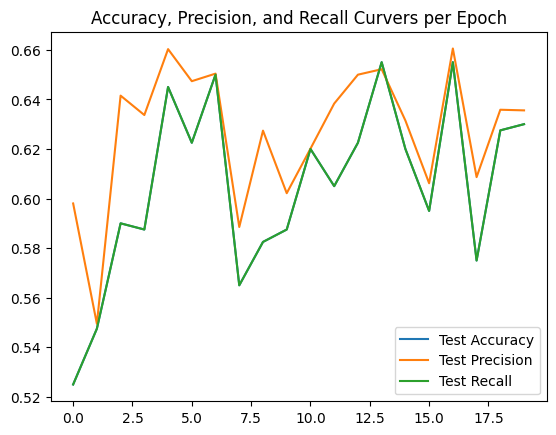

In [ ]:
plt.plot(accuracy_graph, label="Test Accuracy")
plt.plot(precision_graph, label="Test Precision")
plt.plot(recall_graph, label="Test Recall")
plt.title('Accuracy, Precision, and Recall Curvers per Epoch')
plt.legend()

In [24]:
confusion_names = labels.copy()
print(confusion_names)
print(predicted)
arr = confusion_matrix(y_test.cpu().view(-1), predicted.cpu().view(-1))
df_cm = pd.DataFrame(arr, confusion_names, confusion_names)
plt.figure()
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

['H1', 'H2', 'H3', 'H5', 'H6']
tensor([4, 3, 4, 3, 4, 4, 4, 4, 4, 4], device='cuda:0')


ValueError: Found input variables with inconsistent numbers of samples: [400, 10]

In [22]:
pred = labels.index('H6')
lbl = labels.index('H3')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))



RuntimeError: index_select(): Expected dtype int32 or int64 for index

In [20]:
pred = labels.index('H6')
lbl = labels.index('H3')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))



RuntimeError: index_select(): Expected dtype int32 or int64 for index